In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power
# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display['COUNT(*)'].sum()

393063

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

In [13]:
#proprocess cat data profilename
profname = list(final['ProfileName'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
profnamelist = []
for i in profname:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    profnamelist.append(temp.strip())

In [14]:
#remove orignal and create clean cat colu
final['clean_profname'] = profnamelist
final.drop(['ProfileName'], axis=1, inplace=True)
final.head(2)

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,clean_profname
2546,2774,B00002NCJC,A196AJHU9EASJN,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,AlexChaffee
2547,2775,B00002NCJC,A13RRPGE79XFFH,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,reader48


In [15]:
#SUMMARY

In [16]:
# printing some random reviews
print(final['Summary'].values[0])
print("="*50)
print(final['Summary'].values[150])
print("="*50)
print(final['Summary'].values[1000])
print("="*50)
print(final['Summary'].values[4900])
print("="*50)

thirty bucks?
Good stuff!
Best sour cream & onion chip I've had
caribou


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent = decontracted(final['Summary'].values[4500])
print(sent)
print("="*50)

PARTIALLY HYDROGENATED VEGETABLE OIL


In [19]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

PARTIALLY HYDROGENATED VEGETABLE OIL


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

PARTIALLY HYDROGENATED VEGETABLE OIL


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [22]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final, final['Score'], test_size=0.33, stratify = final['Score'])
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [23]:
#train

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summarytr = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['Summary'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_summarytr.append(sent.lower().strip())

100%|███████████████████████████████████| 2237/2237 [00:00<00:00, 14707.42it/s]


In [25]:
#test

In [26]:
from tqdm import tqdm
preprocessed_summaryts = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['Summary'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_summaryts.append(sent.lower().strip())

100%|███████████████████████████████████| 1646/1646 [00:00<00:00, 13822.66it/s]


In [27]:
#CV

In [28]:
from tqdm import tqdm
preprocessed_summarycv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['Summary'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_summarycv.append(sent.lower().strip())

100%|███████████████████████████████████| 1103/1103 [00:00<00:00, 13280.35it/s]


In [29]:
#REview TEXT

In [30]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [31]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [32]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [33]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [34]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [35]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [36]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [37]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [38]:
#train

In [39]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviewstr = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviewstr.append(sentance.strip())

100%|████████████████████████████████████| 2237/2237 [00:01<00:00, 1493.03it/s]


In [40]:
#test

In [41]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviewsts = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviewsts.append(sentance.strip())

100%|████████████████████████████████████| 1646/1646 [00:01<00:00, 1455.85it/s]


In [42]:
#cv

In [43]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviewscv = []
# tqdm is for printing the status bar
for sentance in tqdm(X_cv['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviewscv.append(sentance.strip())

100%|████████████████████████████████████| 1103/1103 [00:00<00:00, 1556.29it/s]


In [44]:
#1-hot

In [45]:
from collections import Counter
my_counter = Counter()
for word in final['clean_profname'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [46]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(X_train['clean_profname'].values)
profname_one_hot_train = vectorizer.transform(X_train['clean_profname'].values)
profname_one_hot_test = vectorizer.transform(X_test['clean_profname'].values)
profname_one_hot_cv = vectorizer.transform(X_cv['clean_profname'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix of Train data after one hot encoding ",profname_one_hot_train.shape)
print("Shape of matrix of Test data after one hot encoding ",profname_one_hot_test.shape)
print("Shape of matrix of CV data after one hot encoding ",profname_one_hot_cv.shape)

['AlexChaffee', 'reader48', 'BGChase', 'Robbie', 'T.Moore"thoughtfulreader"', 'GlennaE.Bauer"PuppyMum"', 'EricHochman', 'InternetDiva', 'KottonKandee"notsosecretshopper"', 'Dr.GlennB.Gero"NJnaturaldoc"', 'BarbKnowsBest', 'S.Jettlund"mamaknows2much"', 'ShalaKerrigan', 'Jim"highaltitudelowopening"', 'D.J.Walters', 'AlwaysFlying', 'MikeJacobs', 'saphenomenon"saphenomenon"', 'S.Woodcock', 'JohnM.Bloom"dmetrixavier"', 'JudyJ.Blaskowski"CoauthorofStepDyna...', 'C.Dembosky', 'J.Jackson', 'C.Goettel', 'PaulJ.Smith', 'BobE', 'Catwoman"Meow."', 'W.Jackson', 'dax', 'S.ANDERSON', 'greycat', 'katereviews', 'Cobra', 'mckay', 'RichardC.Robinson"rickradio"', 'gamerette86', 'TimothyDastis', 'M.Lindsey', 'RobertAshton', 'JessicaZtardust', 'D.Louie', 'MarianneSummers', 'Animallover"BarbJ"', 'CynthiaM.Miller', 'cat', 'D.Latham"unamatrix08"', 'Chocabirdie', 'kentron', 'WinstonC.Hackett"LedHead"', 'S.Smigo', 'J.Ingersoll"FredSchwartz"', 'LD', 'brian@meadows.pair.com', 'Cbougher', 'F.Jones"FJ"', 'Faith', 'A.


Shape of matrix of Train data after one hot encoding  (2237, 4743)
Shape of matrix of Test data after one hot encoding  (1646, 4743)
Shape of matrix of CV data after one hot encoding  (1103, 4743)


In [47]:
#bow sum

In [48]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).

vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(preprocessed_summarytr)
sum_bow_train = vectorizer.transform(preprocessed_summarytr)
print("Shape of matrix after one hot encoding ",sum_bow_train.shape)

Shape of matrix after one hot encoding  (2237, 96)


In [49]:
sum_bow_test = vectorizer.transform(preprocessed_summaryts)
print("Shape of matrix after one hot encoding ",sum_bow_test.shape)

Shape of matrix after one hot encoding  (1646, 96)


In [50]:
sum_bow_cv = vectorizer.transform(preprocessed_summarycv)
print("Shape of matrix after one hot encoding ",sum_bow_cv.shape)

Shape of matrix after one hot encoding  (1103, 96)


In [51]:
#bow review

In [52]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(preprocessed_reviewstr)
text_bow_train = vectorizer.transform(preprocessed_reviewstr)
print("Shape of matrix after one hot encoding ",sum_bow_train.shape)

Shape of matrix after one hot encoding  (2237, 96)


In [53]:
text_bow_test = vectorizer.transform(preprocessed_reviewsts)
print("Shape of matrix after one hot encoding ",text_bow_test.shape)

Shape of matrix after one hot encoding  (1646, 1245)


In [54]:
text_bow_cv = vectorizer.transform(preprocessed_reviewscv)
print("Shape of matrix after one hot encoding ",text_bow_cv.shape)

Shape of matrix after one hot encoding  (1103, 1245)


In [55]:
#tfidf sum

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(preprocessed_summarytr)
sum_tfidf_train = vectorizer.transform(preprocessed_summarytr)
print("Shape of matrix after one hot encoding ",sum_tfidf_train.shape)

Shape of matrix after one hot encoding  (2237, 96)


In [57]:
sum_tfidf_test = vectorizer.transform(preprocessed_summaryts)
print("Shape of matrix after one hot encoding ",sum_tfidf_test.shape)

Shape of matrix after one hot encoding  (1646, 96)


In [58]:
sum_tfidf_cv = vectorizer.transform(preprocessed_summarycv)
print("Shape of matrix after one hot encoding ",sum_tfidf_cv.shape)

Shape of matrix after one hot encoding  (1103, 96)


In [59]:
#tfidf review

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(preprocessed_reviewstr)
text_tfidf_train = vectorizer.transform(preprocessed_reviewstr)
print("Shape of matrix after one hot encoding ",text_tfidf_train.shape)

Shape of matrix after one hot encoding  (2237, 1245)


In [61]:
text_tfidf_test = vectorizer.transform(preprocessed_reviewsts)
print("Shape of matrix after one hot encoding ",text_tfidf_test.shape)

Shape of matrix after one hot encoding  (1646, 1245)


In [62]:
text_tfidf_cv = vectorizer.transform(preprocessed_reviewscv)
print("Shape of matrix after one hot encoding ",text_tfidf_cv.shape)

Shape of matrix after one hot encoding  (1103, 1245)


In [63]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['Time'].values.reshape(-1,1))
T_train = normalizer.transform(X_train['Time'].values.reshape(-1,1))
T_cv = normalizer.transform(X_cv['Time'].values.reshape(-1,1))
T_test = normalizer.transform(X_test['Time'].values.reshape(-1,1))
print("After vectorizations")
print(T_train.shape, y_train.shape)
print(T_cv.shape, y_cv.shape)
print(T_test.shape, y_test.shape)
print("="*100)

After vectorizations
(2237, 1) (2237,)
(1103, 1) (1103,)
(1646, 1) (1646,)


In [65]:
final.head(2)

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,clean_profname
2546,2774,B00002NCJC,A196AJHU9EASJN,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,AlexChaffee
2547,2775,B00002NCJC,A13RRPGE79XFFH,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,reader48


In [ ]:
#SET 1

In [90]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_tr = hstack((profname_one_hot_train,T_train,sum_bow_train)).tocsr()
X_ts = hstack((profname_one_hot_test,T_test,sum_bow_test)).tocsr()
X_cv = hstack((profname_one_hot_cv,T_cv,sum_bow_cv)).tocsr()

In [92]:
print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_ts.shape, y_test.shape)
print("="*100)

Final Data matrix
(2237, 4840) (2237,)
(1103, 4840) (1103,)
(1646, 4840) (1646,)


In [ ]:
#best K at max auc

In [73]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|██████████████████████████████████████████| 10/10 [00:03<00:00,  2.74it/s]


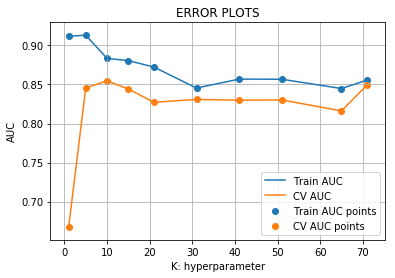

In [75]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
a = []
b = []

K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71]

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cv)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    a.append(y_train_pred)
    b.append(y_cv_pred)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

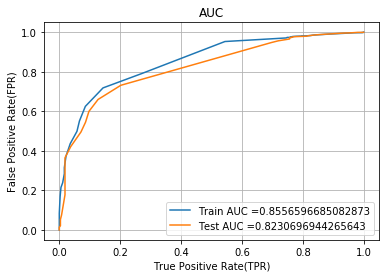

In [76]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=71)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_ts)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [ ]:
#gridsearch cv

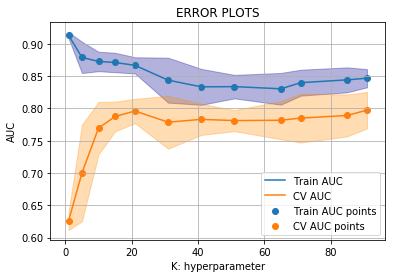

In [77]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51, 65, 71, 85, 91]}
clf = GridSearchCV(neigh, parameters, cv= 5, scoring='roc_auc')
clf.fit(X_tr, y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')
plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

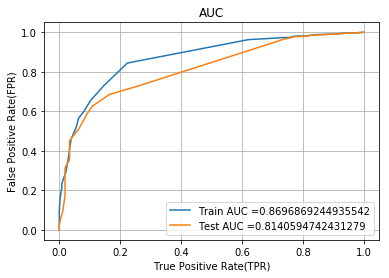

In [78]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=91)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_ts)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [ ]:
#cofusion matrix

In [79]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [80]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.23522633619242392 for threshold 0.725
[[ 137  225]
 [  70 1805]]


In [81]:
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.23522633619242392 for threshold 0.725


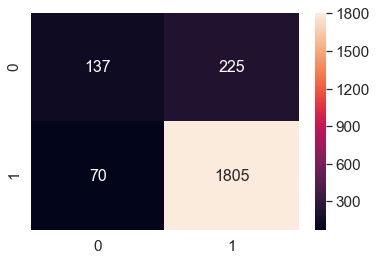

In [82]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 16}, fmt='g')

In [83]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.2003394633113103 for threshold 0.736
[[ 197   70]
 [ 373 1006]]


In [84]:
conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2003394633113103 for threshold 0.736


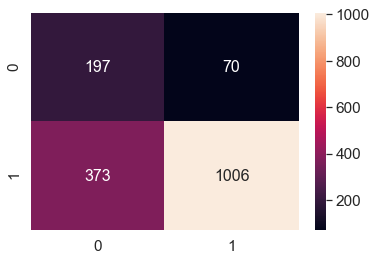

In [85]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

In [87]:
#SET 2

In [111]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_tr = hstack((profname_one_hot_train,T_train,sum_tfidf_train)).tocsr()
X_ts = hstack((profname_one_hot_test,T_test,sum_tfidf_test)).tocsr()
X_cv = hstack((profname_one_hot_cv,T_cv,sum_tfidf_cv)).tocsr()

In [112]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|██████████████████████████████████████████| 10/10 [00:03<00:00,  2.69it/s]


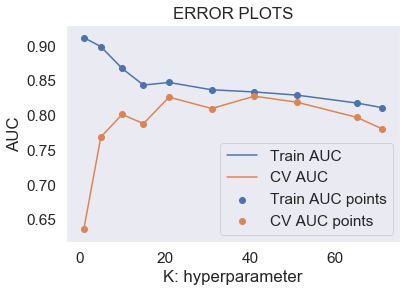

In [113]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
a = []
b = []

K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71]

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cv)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    a.append(y_train_pred)
    b.append(y_cv_pred)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

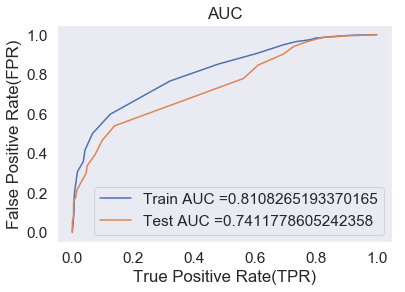

In [114]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=71)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_ts)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

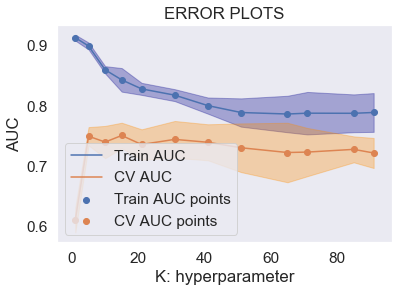

In [115]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51, 65, 71, 85, 91]}
clf = GridSearchCV(neigh, parameters, cv= 5, scoring='roc_auc')
clf.fit(X_tr, y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')
plt.scatter(parameters['n_neighbors'], train_auc, label='Train AUC points')
plt.scatter(parameters['n_neighbors'], cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

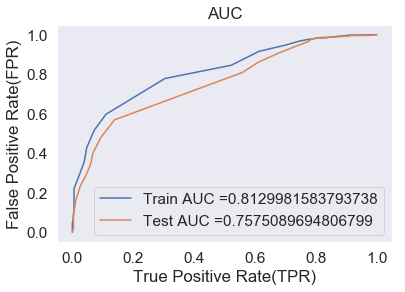

In [116]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=91)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_ts)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [117]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [118]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24951161441958425 for threshold 0.758
[[ 173  189]
 [ 290 1585]]


In [119]:
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24951161441958425 for threshold 0.758


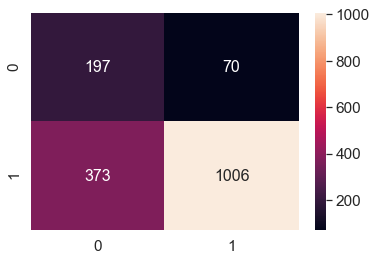

In [120]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

In [121]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24662991485362398 for threshold 0.791
[[242  25]
 [717 662]]


In [122]:
conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24662991485362398 for threshold 0.791


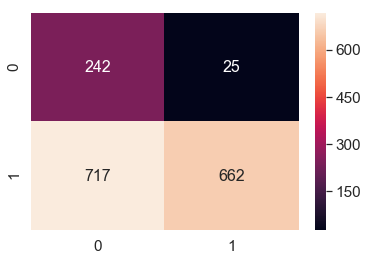

In [123]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

In [ ]:
#SET 3

In [158]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_tr = hstack((profname_one_hot_train,T_train,text_bow_train)).tocsr()
X_ts = hstack((profname_one_hot_test,T_test,text_bow_test)).tocsr()
X_cv = hstack((profname_one_hot_cv,T_cv,text_bow_cv)).tocsr()

In [159]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|██████████████████████████████████████████| 10/10 [00:04<00:00,  2.23it/s]


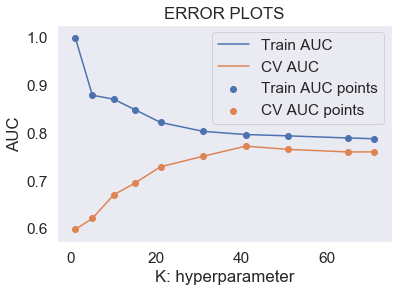

In [160]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
a = []
b = []

K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71]

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cv)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    a.append(y_train_pred)
    b.append(y_cv_pred)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

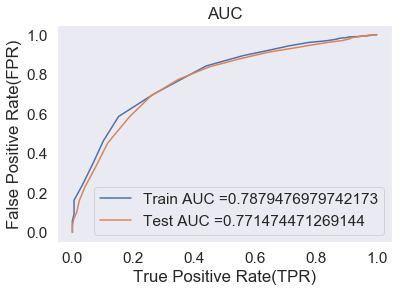

In [161]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=71)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_ts)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [162]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [163]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.246306584048106 for threshold 0.803
[[ 159  203]
 [ 199 1676]]


In [164]:
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.246306584048106 for threshold 0.803


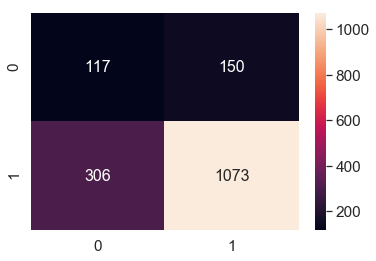

In [165]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

In [166]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24744350460800404 for threshold 0.817
[[ 147  120]
 [ 225 1154]]


In [167]:
conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.24744350460800404 for threshold 0.817


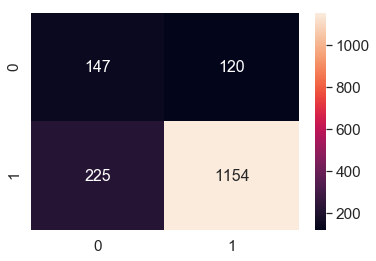

In [168]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

In [169]:
#SET 4

In [172]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_tr = hstack((profname_one_hot_train,T_train,text_tfidf_train)).tocsr()
X_ts = hstack((profname_one_hot_test,T_test,text_tfidf_test)).tocsr()
X_cv = hstack((profname_one_hot_cv,T_cv,text_tfidf_cv)).tocsr()

In [173]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_tr = hstack((profname_one_hot_train,T_train,text_bow_train)).tocsr()
X_ts = hstack((profname_one_hot_test,T_test,text_tfidf_test)).tocsr()
X_cv = hstack((profname_one_hot_cv,T_cv,text_tfidf_cv)).tocsr()

100%|██████████████████████████████████████████| 10/10 [00:04<00:00,  2.17it/s]


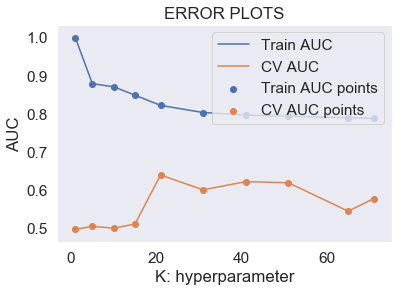

In [174]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
a = []
b = []

K = [1, 5, 10, 15, 21, 31, 41, 51, 65, 71]

for i in tqdm(K):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_tr, y_train)

    y_train_pred = batch_predict(neigh, X_tr)    
    y_cv_pred = batch_predict(neigh, X_cv)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    a.append(y_train_pred)
    b.append(y_cv_pred)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

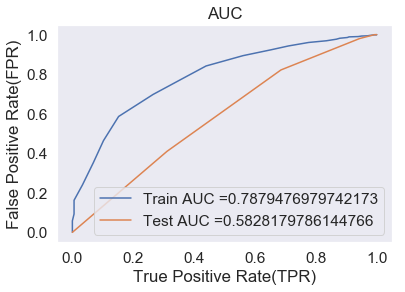

In [175]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=71)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_ts)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [176]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [177]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.246306584048106 for threshold 0.803
[[ 159  203]
 [ 199 1676]]


In [178]:
conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.246306584048106 for threshold 0.803


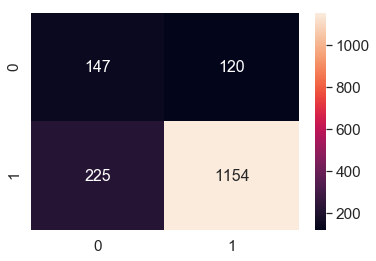

In [179]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

In [180]:
print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)))

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.2156293397298321 for threshold 0.986
[[ 267    0]
 [1379    0]]


In [181]:
conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

the maximum value of tpr*(1-fpr) 0.2156293397298321 for threshold 0.986


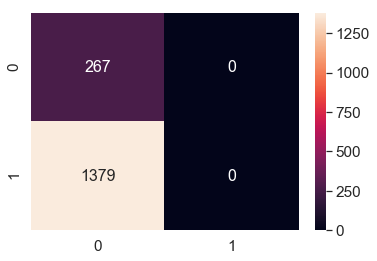

In [182]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')